In [1]:
import os
import gc
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import whisper
from dataclasses import dataclass, field, replace
from whisper.decoding import DecodingTask
from whisper.audio import (
    log_mel_spectrogram,
    pad_or_trim,
    load_audio,
)

seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from jiwer import wer

from data import *
from suta import *
from omegaconf import OmegaConf
args = OmegaConf.load("config.yaml")

dataset = load_dataset(['test-other'], 'librispeech', 'LibriSpeech', 1, extra_noise=0.01)



/home/allen172/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Read text: 100%|██████████| 2939/2939 [00:00<00:00, 23463.40it/s]


[INFO]    There are 2939 samples.


0it [00:00, ?it/s]

[INFO]    optimizer: <class 'torch.optim.adamw.AdamW'>
[INFO]    scheduler: None


1it [02:50, 170.85s/it]

[INFO]    optimizer: <class 'torch.optim.adamw.AdamW'>
[INFO]    scheduler: None


1it [04:16, 256.46s/it]


KeyboardInterrupt: 

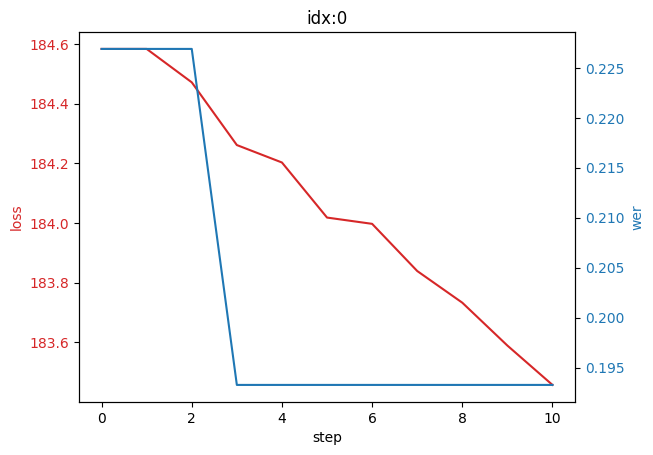

In [2]:
teacher_tokens = []
from whisper.normalizers import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()
options = whisper.DecodingOptions(language="en", without_timestamps=True)
exp_name = 'ex_data/suta_ex'
with open(f'{exp_name}/transcript.txt', 'a') as f:

    for count, batch in tqdm(enumerate(dataset)):
        if count > 100:
            break
        # load model
        model = whisper.load_model(args.asr)
        model.eval()
        task = DecodingTask(model, options)

        # set training param
        params, names = whisper_collect_params(model, args.encoderLN, args.decoderLN, train_feature=args.train_feature)
        optimizer, scheduler = setup_optimizer(params, args.opt, 2e-5, scheduler=None)

        # unzip batch
        lens, wavs, texts, files = batch
        f.write(f'idx:{count}'+'\n')
        f.write('label:'+normalizer(texts[0])+'\n')

        # preprocess data
        if args.asr == 'large' or args.asr == 'large_v2' or args.asr == 'large_v3': # the code is for batch size = 1
            mel = log_mel_spectrogram(pad_or_trim(wavs[0]), n_mels=128).unsqueeze(0).to(DEVICE)
        else:
            mel = log_mel_spectrogram(pad_or_trim(wavs[0])).unsqueeze(0).to(DEVICE)

        losses = []
        wers = []
        # original whisper output
        with torch.no_grad():
            result = model.decode(mel, options)[0]
            teacher_tokens = result.tokens
            text = result.text
            ori_wer = wer(normalizer(texts[0]), normalizer(text))
            wers.append(ori_wer)
        f.write(f'ori({ori_wer}):{text}\n')
        del result
        torch.cuda.empty_cache()
        
        # teacher forcing to get logit
        options = whisper.DecodingOptions(language="en", without_timestamps=True)
        task = DecodingTask(model, options)
        if options.beam_size is not None:
            n_batch = options.beam_size
        else:
            n_batch = 1

        # SGEM or SUTA
        for step in range(args.steps):
            model.zero_grad()
            audio_features = task._get_audio_features(mel)
            tokens = torch.tensor([task.initial_tokens]).repeat(1, 1).to(device=audio_features.device)
            tokens = tokens.repeat_interleave(task.n_group, dim=0).to(audio_features.device)
            sum_logprobs = torch.zeros(n_batch, device=audio_features.device)

            loss = 0
            entropy_list = None
            negative_loss = 0
            for i in range(len(teacher_tokens)):
                added_token = torch.Tensor([[teacher_tokens[i]]]).long().expand(tokens.shape[0], 1).to(DEVICE)
                tokens = torch.cat((tokens, added_token), dim=1)
                logits = task.inference.logits(tokens, audio_features) # (1,2,51864)
                
                logits = logits[:, -1]
                for logit_filter in task.logit_filters:
                    logit_filter.apply(logits, tokens)
                
                logits = torch.topk(logits, k=30).values

                # SUTA
                e_loss = softmax_entropy(logits.unsqueeze(0) / args.temp).mean(0).mean()
                loss += e_loss * args.em_coef
                c_loss = mcc_loss(logits.unsqueeze(0) / args.temp, class_num=args.topk)
                loss += c_loss * (1 - args.em_coef)

                # # GEM
                # entropy = torch.log(torch.pow(logits.softmax(dim=-1), args.renyi_entropy_alpha).sum(dim=-1)) # entropy: B, L
                # entropy = entropy / (1 - args.renyi_entropy_alpha)
                # entropy = entropy.mean()
                # if entropy_list is None:
                #     entropy_list = entropy.unsqueeze(0)
                # else:
                #     entropy_list = torch.cat((entropy.unsqueeze(0), entropy_list), dim=-1)

                # # NS
                # negative_outputs = logits.clone()
                # negative_mask = torch.where(torch.softmax(negative_outputs, dim=-1) < args.ns_threshold * (10 / negative_outputs.shape[-1]), 1, 0)
                # negative_loss += torch.mean(-torch.log(1 - torch.sum(negative_mask * torch.softmax(negative_outputs / args.temp, dim=-1), dim=-1)))

            # e_loss = entropy_list.mean()
            # loss = args.ns_coef * negative_loss + e_loss
            losses.append(loss)
            if step==0:
                losses.append(loss)
            loss.backward()
            optimizer.step()
            task.inference.cleanup_caching()

            # output after adaptation
            options = whisper.DecodingOptions(language="en", without_timestamps=True)
            task = DecodingTask(model, options)
            with torch.no_grad():
                after_text = model.decode(mel, options)[0].text
            after_wer = wer(normalizer(texts[0]), normalizer(after_text))
            f.write(f'step{step}({after_wer}): {after_text}\n')
            wers.append(after_wer)
            del logits
            torch.cuda.empty_cache()

        # plot loss curve and wer
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('step')
        ax1.set_ylabel('loss', color=color)
        ax1.plot([loss.cpu().detach() for loss in losses], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # 在右側 y 軸上繪製 data2
        ax2 = ax1.twinx()  # 共享 x 軸
        color = 'tab:blue'
        ax2.set_ylabel('wer', color=color)
        ax2.plot(wers, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.title(f'idx:{count}')
        plt.savefig(f'./ex_data/suta_ex/suta_{count}.png')

        f.write("=======================================\n")
        

In [ ]:
teacher_tokens = []
from whisper.normalizers import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()
options = whisper.DecodingOptions(language="en", without_timestamps=True)
exp_name = 'ex_data/sgem_ex'
with open(f'{exp_name}/transcript.txt', 'a') as f:

    for count, batch in tqdm(enumerate(dataset)):
        if count > 100:
            break
        # load model
        model = whisper.load_model(args.asr)
        model.eval()
        task = DecodingTask(model, options)

        # set training param
        params, names = whisper_collect_params(model, args.encoderLN, args.decoderLN, train_feature=args.train_feature)
        optimizer, scheduler = setup_optimizer(params, args.opt, 2e-5, scheduler=None)

        # unzip batch
        lens, wavs, texts, files = batch
        f.write(f'idx:{count}'+'\n')
        f.write('label:'+normalizer(texts[0])+'\n')

        # preprocess data
        if args.asr == 'large' or args.asr == 'large_v2' or args.asr == 'large_v3': # the code is for batch size = 1
            mel = log_mel_spectrogram(pad_or_trim(wavs[0]), n_mels=128).unsqueeze(0).to(DEVICE)
        else:
            mel = log_mel_spectrogram(pad_or_trim(wavs[0])).unsqueeze(0).to(DEVICE)

        losses = []
        wers = []
        # original whisper output
        with torch.no_grad():
            result = model.decode(mel, options)[0]
            teacher_tokens = result.tokens
            text = result.text
            ori_wer = wer(normalizer(texts[0]), normalizer(text))
            wers.append(ori_wer)
        f.write(f'ori({ori_wer}):{text}\n')
        del result
        torch.cuda.empty_cache()
        
        # teacher forcing to get logit
        options = whisper.DecodingOptions(language="en", without_timestamps=True)
        task = DecodingTask(model, options)
        if options.beam_size is not None:
            n_batch = options.beam_size
        else:
            n_batch = 1

        # SGEM or SUTA
        for step in range(args.steps):
            model.zero_grad()
            audio_features = task._get_audio_features(mel)
            tokens = torch.tensor([task.initial_tokens]).repeat(1, 1).to(device=audio_features.device)
            tokens = tokens.repeat_interleave(task.n_group, dim=0).to(audio_features.device)
            sum_logprobs = torch.zeros(n_batch, device=audio_features.device)

            loss = 0
            entropy_list = None
            negative_loss = 0
            for i in range(len(teacher_tokens)):
                added_token = torch.Tensor([[teacher_tokens[i]]]).long().expand(tokens.shape[0], 1).to(DEVICE)
                tokens = torch.cat((tokens, added_token), dim=1)
                logits = task.inference.logits(tokens, audio_features) # (1,2,51864)
                
                logits = logits[:, -1]
                for logit_filter in task.logit_filters:
                    logit_filter.apply(logits, tokens)
                
                logits = torch.topk(logits, k=30).values

                # # SUTA
                # e_loss = softmax_entropy(logits.unsqueeze(0) / args.temp).mean(0).mean()
                # loss += e_loss * args.em_coef
                # c_loss = mcc_loss(logits.unsqueeze(0) / args.temp, class_num=args.topk)
                # loss += c_loss * (1 - args.em_coef)

                # GEM
                entropy = torch.log(torch.pow(logits.softmax(dim=-1), args.renyi_entropy_alpha).sum(dim=-1)) # entropy: B, L
                entropy = entropy / (1 - args.renyi_entropy_alpha)
                entropy = entropy.mean()
                if entropy_list is None:
                    entropy_list = entropy.unsqueeze(0)
                else:
                    entropy_list = torch.cat((entropy.unsqueeze(0), entropy_list), dim=-1)

                # NS
                negative_outputs = logits.clone()
                negative_mask = torch.where(torch.softmax(negative_outputs, dim=-1) < args.ns_threshold * (10 / negative_outputs.shape[-1]), 1, 0)
                negative_loss += torch.mean(-torch.log(1 - torch.sum(negative_mask * torch.softmax(negative_outputs / args.temp, dim=-1), dim=-1)))

            e_loss = entropy_list.mean()
            loss = args.ns_coef * negative_loss + e_loss
            losses.append(loss)
            if step==0:
                losses.append(loss)
            loss.backward()
            optimizer.step()
            task.inference.cleanup_caching()

            # output after adaptation
            options = whisper.DecodingOptions(language="en", without_timestamps=True)
            task = DecodingTask(model, options)
            with torch.no_grad():
                after_text = model.decode(mel, options)[0].text
            after_wer = wer(normalizer(texts[0]), normalizer(after_text))
            f.write(f'step{step}({after_wer}): {after_text}\n')
            wers.append(after_wer)
            del logits, negative_outputs
            torch.cuda.empty_cache()

        # plot loss curve and wer
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('step')
        ax1.set_ylabel('loss', color=color)
        ax1.plot([loss.cpu().detach() for loss in losses], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # 在右側 y 軸上繪製 data2
        ax2 = ax1.twinx()  # 共享 x 軸
        color = 'tab:blue'
        ax2.set_ylabel('wer', color=color)
        ax2.plot(wers, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.title(f'idx:{count}')
        plt.savefig(f'./ex_data/sgem_ex/sgem_{count}.png')

        f.write("=======================================\n")
        

In [8]:
def find_different_words(sentence1, sentence2):
    # 將句子轉換成集合，其中集合會自動去除重複的單字
    words_set1 = set(sentence1.split())
    words_set2 = set(sentence2.split())
    
    # 找出兩個句子中不同的單字
    different_words = words_set1.symmetric_difference(words_set2)
    
    return different_words

# 例子
sentence1 = "They've indigently over the board. Each watching with feverish anxiety was companions movements. Each casting, now and again, a gloating eye upon the keep of gold and greenbacks that lay between them. And at times, half stretching out this hand, watching."
sentence2 = "They've indigently over the board. Each watching with feverish anxiety is companions movements. Each casting now and again, a gloating eye upon the keep of gold and greenbacks that lay between them. And at times, half stretching out his hand, watching."
result = find_different_words(sentence1, sentence2)
print("不同的單字:", result)

不同的單字: {'his', 'casting,', 'was', 'this', 'casting', 'is'}


In [ ]:
for i in range(len(ori_wer)):
    if ori_wer[i] - after_wer[i] < -0.2:
        print(ori_wer[i])
        print(after_wer[i])
        print('===')

In [ ]:
import numpy as np
np.array(ori_wer).mean()

0.23204044255065828

In [ ]:
np.array(after_wer).mean()

0.23295592382468738

In [ ]:
# ori whisper code
count = 0
options = whisper.DecodingOptions(language="en", beam_size=4, without_timestamps=True)
for batch in tqdm(dataset):
    count+=1
    if count > 1:
        break
    model = whisper.load_model(args.asr)
    model.eval()
    task = DecodingTask(model, options)
    task.decoder.reset()
    lens, wavs, texts, files = batch
    # the code is for batch size = 1
    if args.asr == 'large' or args.asr == 'large_v2' or args.asr == 'large_v3':
        mel = log_mel_spectrogram(pad_or_trim(wavs[0]), n_mels=128).unsqueeze(0).to(DEVICE)
    else:
        mel = log_mel_spectrogram(pad_or_trim(wavs[0])).unsqueeze(0).to(DEVICE)
    audio_features = task._get_audio_features(mel)
    tokens = torch.tensor([task.initial_tokens]).repeat(1, 1).to(device=audio_features.device)
    tokens = tokens.repeat_interleave(task.n_group, dim=0).to(audio_features.device)
    languages, language_probs = task._detect_language(audio_features, tokens)
    n_batch = tokens.shape[0]
    sum_logprobs = torch.zeros(n_batch, device=audio_features.device)
    try:
        for i in range(task.sample_len):
            logits = task.inference.logits(tokens, audio_features) # (1,2,51864)
            if (
                i == 0 and task.tokenizer.no_speech is not None
            ):  # save no_speech_probs
                probs_at_sot = logits[:, task.sot_index].float().softmax(dim=-1)
                no_speech_probs = probs_at_sot[:, task.tokenizer.no_speech].tolist()

            # now we need to consider the logits at the last tokens only
            logits = logits[:, -1]
            print(logits)
            raise

            # apply the logit filters, e.g. for suppressing or applying penalty to
            for logit_filter in task.logit_filters:
                logit_filter.apply(logits, tokens)

            # expand the tokens tensor with the selected next tokens
            tokens, completed, logit_rank = task.decoder.update(tokens, logits, sum_logprobs)

            if completed or tokens.shape[-1] > task.n_ctx:
                break
    finally:
        task.inference.cleanup_caching()
    break

In [ ]:
# audio feature shape
after_text[0].audio_features.shape

torch.Size([1500, 384])

In [ ]:
e_loss = entropy_list.mean()

tensor(2.1302, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
args.ns_coef * negative_loss + e_loss

tensor(4.0887, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
logits.shape

torch.Size([1, 51865])

In [ ]:
non_inf_idx = torch.isfinite(logits)
num_finite_values = torch.sum(non_inf_idx).item()
num_finite_values

51777

In [ ]:
non_inf_idx = torch.isfinite(logit_arr[0])
logit_arr[0][non_inf_idx].shape

torch.Size([51777])

In [ ]:
torch.topk(logits,k=30).values

tensor([[22.3750, 21.5938, 20.7500, 19.7500, 19.5938, 19.5156, 19.0938, 18.9375,
         18.9219, 18.8906, 18.7812, 18.6562, 18.6250, 18.5625, 18.4219, 18.4062,
         18.2969, 18.2656, 18.2344, 18.2031, 18.1406, 18.0625, 18.0625, 18.0312,
         18.0156, 17.9531, 17.9375, 17.8750, 17.8438, 17.7969]],
       device='cuda:0', grad_fn=<TopkBackward0>)